In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [137]:
import scipy.io as sio
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os

from torch.utils.data import DataLoader, Dataset, TensorDataset
from utils.EmoPainDataset import KinematicsDataset, SlidingWindowDataset, create_weighted_sampler
from utils.models import KinematicsTransformer, KinematicsLSTM, FocalLoss, BANet, MultiTaskTransformer
from sklearn.metrics import balanced_accuracy_score
from utils.training import train_transformer, pretrain_transformer, train_multi_task_model
from utils.model_analysis import get_first_attention_weights

filepath='EmoPainData/P.feather'

sampling_frequency = 60

In [58]:
# read dataframe
df=pd.read_feather(filepath)
#df=pd.concat([pd.read_feather('EmoPainData/P.feather'), pd.read_feather('EmoPainData/C.feather')], axis=0, ignore_index=True)

# reset index
df.reset_index(drop=True, inplace=True)  

# drop 'nan' in column names
df.columns = [feature[:-4] if (feature.find('nan')!=-1) else feature for feature in df.columns] 

# calculate a soft probability of protective behaviors
behavior_ratings=[feature for feature in df.columns if feature.find('Rater')!=-1]
df.insert(df.shape[-1], 'behavior prob', (df[behavior_ratings]/2).mean(axis=1)) # divided by 2 because the max label is 2

# calculate a binary label of protective behaviors based on the majority voting used in the original paper and Wang et. al 
binary_labels_per_rater, PB_label=pd.DataFrame(), pd.DataFrame()
for rater_num in range(1,5):    # loop through all 4 raters
    behavior_ratings=[feature for feature in df.columns if feature.find('Rater '+str(rater_num))!=-1]
    # the maximum label of each frame given by each rater
    pb = df[behavior_ratings].max(axis=1)
    PB_label.insert(rater_num-1,str(rater_num), pb)
    # create a binary label based on majority voting of all 4 raters
    binary_label = ((df[behavior_ratings]==1) | (df[behavior_ratings]==2)).max(axis=1)
    binary_labels_per_rater.insert(rater_num-1,str(rater_num), binary_label)
    
majority_voting_binary_label = (binary_labels_per_rater.sum(axis=1)>=2).astype(int)
df.insert(df.shape[-1], 'behavior binary', majority_voting_binary_label)
df.insert(df.shape[-1], 'PB prob', PB_label.mean(axis=1)/2)

# extract joint locations as new columns in the dataframe (26 joints x 3 = 78 columns)
point_names = [joint_name+axis for joint_name in df.columns[:26] for axis in ['_X', '_Y', '_Z'] ]
points=np.array(df.iloc[:,:26].to_numpy().tolist(), dtype=float)
points=points.reshape(points.shape[0], -1)
df = pd.concat([df, pd.DataFrame(points, columns=point_names)], axis=1)

In [5]:
print(df.columns.to_numpy())

['Hip' 'LeftUpperLeg' 'LeftLowerLeg' 'LeftAnkle' 'LeftHeel' 'LeftToes'
 'RightUpperLeg' 'RightLowerLeg' 'RightAnkle' 'RightHeel' 'RightToes'
 'Spine' 'Spine 1' 'LeftShoulder' 'LeftUpperArm' 'LeftLowerArm'
 'LeftWrist' 'LeftFingertip' 'RightShoulder' 'RightUpperArm' 'RightArm'
 'RightWrist' 'RightFingertip' 'Neck' 'Head' 'Crown'
 'Rectified EMG Probe 1:Right Lower' 'Rectified EMG Probe 2:Left Lower'
 'Rectified EMG Probe 3:Right Upper' 'Recfified EMG Probe 4:Left Upper'
 'Rater 1- Guarding/Stiffness' 'Rater 1- Hesitation'
 'Rater 1- Support/Bracing' 'Rater 1- Jerky Motion' 'Rater 1 - Limping'
 'Rater 1 - Rubbing/Stimulation' 'Rater 1 - Other'
 'Rater 2- Guarding/Stiffness' 'Rater 2- Hesitation'
 'Rater 2- Support/Bracing' 'Rater 2- Jerky Motion' 'Rater 2 - Limping'
 'Rater 2 - Rubbing/Stimulation' 'Rater 2 - Other'
 'Rater 3- Guarding/Stiffness' 'Rater 3- Hesitation'
 'Rater 3- Support/Bracing' 'Rater 3- Jerky Motion' 'Rater 3 - Limping'
 'Rater 3 - Rubbing/Stimulation' 'Rater 3 - Other

In [5]:
behavior_ratings=[feature for feature in df.columns if feature.find('Rater')!=-1]
print(df.shape)
print((df[behavior_ratings]==0).sum(axis=0)/df.shape[0])
print((df[behavior_ratings]==1).sum(axis=0)/(df[behavior_ratings]==2).sum(axis=0))

(473210, 113)
Rater 1- Guarding/Stiffness      0.962782
Rater 1- Hesitation              0.997483
Rater 1- Support/Bracing         0.991701
Rater 1- Jerky Motion            0.992327
Rater 1 - Limping                0.992158
Rater 1 - Rubbing/Stimulation    0.997969
Rater 1 - Other                  0.998599
Rater 2- Guarding/Stiffness      0.782498
Rater 2- Hesitation              0.997099
Rater 2- Support/Bracing         0.963226
Rater 2- Jerky Motion            0.952554
Rater 2 - Limping                0.948040
Rater 2 - Rubbing/Stimulation    0.987834
Rater 2 - Other                  1.000000
Rater 3- Guarding/Stiffness      0.903559
Rater 3- Hesitation              0.998614
Rater 3- Support/Bracing         0.970436
Rater 3- Jerky Motion            0.984527
Rater 3 - Limping                0.981625
Rater 3 - Rubbing/Stimulation    0.997394
Rater 3 - Other                  0.997416
Rater 4- Guarding/Stiffness      0.708066
Rater 4- Hesitation              0.989816
Rater 4- Support/Bra

In [234]:
from utils.EmoPainDataset import KinematicsDataset, SlidingWindowDataset
from utils.config import activity_cols

# Load the dataset
    # indicate which features to use
subjects = df.Subject.unique()
leave_out_subjects = [subjects[0], subjects[-1]]
kinematic_features=[feature for feature in df.columns if feature.find('Energy')!=-1 or feature.find('Angle')!=-1 ]
behavior_ratings=[feature for feature in df.columns if feature.find('Rater')!=-1]
PB_prob=['PB prob']
behavior_prob=['behavior prob']
behavior_binary=['behavior binary']
point_locations = df.columns[-78:]
target_features = behavior_binary # target
df = df.dropna(subset=kinematic_features,)  # the first sample for each subject is nan for energy features; so drop them
#
window_size, step_size = int(sampling_frequency*3), int(sampling_frequency*0.75)  # experiment parameters

dataset = SlidingWindowDataset(df, leave_out_subjects, kinematic_features, target_features, 'Subject', window_size, step_size,\
                                activity_cols=activity_cols,)
test_features, test_targets = dataset.get_test_data()
print(test_features.shape, test_targets.shape)
#  
reconstruction_dataset = SlidingWindowDataset(df, leave_out_subjects, kinematic_features, kinematic_features, 'Subject', window_size, step_size,\
                                               activity_cols=activity_cols, per_frame_label=True, targe_scaling=True)
_, test_reconstructions = reconstruction_dataset.get_test_data()
print(test_reconstructions.shape)
#  
point_dataset = SlidingWindowDataset(df, leave_out_subjects, kinematic_features, point_names, 'Subject', window_size, step_size,\
                                      activity_cols=activity_cols, per_frame_label=True, targe_scaling=True)
_, test_points = point_dataset.get_test_data()
print(test_points.shape)
#
activity_dataset = SlidingWindowDataset(df, leave_out_subjects, kinematic_features, activity_cols, 'Subject', window_size, step_size,\
                                         activity_cols=activity_cols, per_frame_label=True)
_, test_activitys = activity_dataset.get_test_data()
print(test_activitys.shape)

torch.Size([210, 180, 26]) torch.Size([210, 1])
torch.Size([210, 180, 26])
torch.Size([210, 180, 78])
torch.Size([210, 180, 24])


In [ ]:
#   1. majority voting of maximum labels (the label of a frame from a single rater is the max label they give across all 7 PBs)
    #   a. per-frame prediction
    #   b. per-sequence prediction (majority voting of frames)

#   2. mean scores as labels across all raters and all categories, divided by 2
    #   a. per-frame prediction
    #   b. per-sequence prediction (mean of frames)



#   Pre-training schemes
    #   1. Transformer
        #   a. Train the encoder and decoder to predict the activity at each frame
        #   b. Train the encoder and decoder to 
        #   c. Evaluate the pre-trained model on the test set
    #   2.  LSTM
    #   3.  Point-Net


#   Fine-tuning schemes

In [ ]:
import seaborn as sns
sns.boxplot(df[kinematic_features])

In [243]:
# Hyperparameters
input_dim = test_features.shape[-1]           # Number of features in each kinematics sample
num_classes = 2
seq_len = window_size       # Sequence length (window length)
embed_dim = 64             # Embedding dimension
num_heads = 8               # Number of attention heads
num_layers = 4              # Number of transformer layers
dropout = 0.1               # Dropout rate
lr = 3e-3                   # Learning rate
masking_prob = 0.3          # Probability of masking each feature
pretrain_epochs = 100       # Pretraining epochs
fine_tune_epochs = 10       # Fine-tuning epochs
batch_size = 64             # Batch size
body_part_num = 13
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Initialize model
model = KinematicsTransformer(input_dim, num_classes, seq_len, embed_dim, num_heads, num_layers, dropout)
#model = BANet(input_dim//body_part_num, embed_dim, num_classes, num_layers, body_part_num, dropout)
#model = KinematicsLSTM(input_dim, embed_dim, num_classes, num_layers, dropout, bidirectional=True)
#model = MultiTaskTransformer(input_dim, 26*3, embed_dim, num_heads, num_layers, num_classes_pain=3, num_classes_behavior=2, num_classes_activity=24)
torch.cuda.empty_cache()
# summary
print(f"Number of trainable parameters: %d" % sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters: 1136732


In [239]:
# Dataloader preperation
# Create a weighted sampler
weighted_sampler = create_weighted_sampler(dataset, num_bins=2)

# PB prediction DataLoader with weighted sampling
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=weighted_sampler)
test_features, test_targets = dataset.get_test_data()
val_loader = DataLoader(TensorDataset(test_features, test_targets), batch_size=batch_size)
# reconstruction task dataloader
reconstruction_train_loader = DataLoader(reconstruction_dataset, batch_size=batch_size, sampler=None)
reconstruction_val_loader = DataLoader(TensorDataset(*reconstruction_dataset.get_test_data()), batch_size=batch_size)
# joint prediction task dataloader
joint_train_loader = DataLoader(point_dataset, batch_size=batch_size, sampler=None)
joint_val_loader = DataLoader(TensorDataset(*point_dataset.get_test_data()), batch_size=batch_size)
# activity prediction task dataloader
activity_train_loader = DataLoader(activity_dataset, batch_size=batch_size, sampler=None)
activity_val_loader = DataLoader(TensorDataset(*activity_dataset.get_test_data()), batch_size=batch_size)
# 
train_dataloaders = {
    'reconstruct_kinematics': reconstruction_train_loader,
    'predict_activity': activity_train_loader,
    'predict_joint': joint_train_loader,
    'predict_behavior': train_loader,
}
val_dataloaders = {
    'reconstruct_kinematics': reconstruction_val_loader,
    'predict_activity': activity_val_loader,
    'predict_joint': joint_val_loader,
    'predict_behavior': val_loader,
}
lr_backbone = {
    'predict_joint': 3e-3,
    'predict_behavior': 0,
    'predict_activity': 0,
    'predict_pain': 0,
    'reconstruct_kinematics': 3e-3,
}
lr_head = {       
    'predict_joint': 3e-3,
    'predict_behavior': 3e-3,
    'predict_activity': 3e-3,
    'predict_pain': 3e-3,
    'reconstruct_kinematics': 3e-3,
}

In [ ]:
# train multi-task models
""" tasks=[
    "predict_behavior",
        ]
model = MultiTaskTransformer(input_dim, 26*3, embed_dim, num_heads, num_layers, num_classes_pain=3, num_classes_behavior=2, num_classes_activity=24)
torch.cuda.empty_cache()
log_no_pretrain = train_multi_task_model(model, train_dataloaders, val_dataloaders, tasks, num_epochs=100, lr_main=lr_backbone, lr_head=lr_head, device=device
        ) """

tasks=[
    "reconstruct_kinematics",
    "predict_behavior",
        ]
model = MultiTaskTransformer(input_dim, 26*3, embed_dim, num_heads, num_layers, num_classes_pain=3, num_classes_behavior=2, num_classes_activity=24)
torch.cuda.empty_cache()
log_pretrain_with_rec = train_multi_task_model(model, train_dataloaders, val_dataloaders, tasks, num_epochs=100, lr_main=lr_backbone, lr_head=lr_head, device=device
        )

tasks=[
    "reconstruct_kinematics",
    "predict_joint", 
    #"predict_activity",
    "predict_behavior",
        ]
model = MultiTaskTransformer(input_dim, 26*3, embed_dim, num_heads, num_layers, num_classes_pain=3, num_classes_behavior=2, num_classes_activity=24)
torch.cuda.empty_cache()
log_pretrain_with_rec_and_joint = train_multi_task_model(model, train_dataloaders, val_dataloaders, tasks, num_epochs=100, lr_main=lr_backbone, lr_head=lr_head, device=device
        )

<Axes: xlabel='epoch', ylabel='val_behavior_loss'>

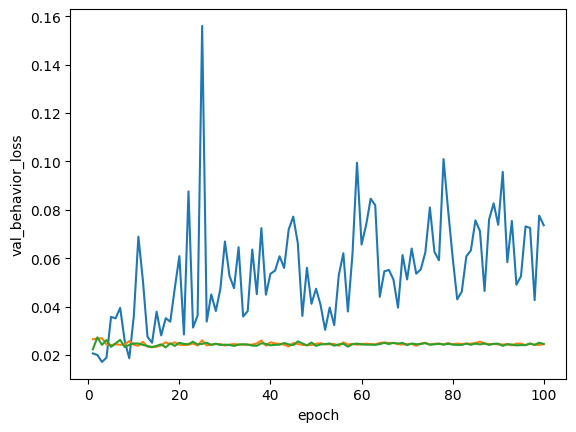

In [232]:
import seaborn as sns
#sns.lineplot(log_no_pretrain, x='epoch', y= 'val_behavior_balanced_accuracy')
#sns.lineplot(log_pretrain_with_rec, x='epoch', y= 'val_joint_loss')
#sns.lineplot(log_pretrain_with_rec_and_joint, x='epoch', y= 'val_reconstruction_loss')
#sns.lineplot(log_dataframe, x='epoch', y= 'val_activity_loss')

""" sns.lineplot(log_no_pretrain, x='epoch', y= 'val_behavior_balanced_accuracy')
sns.lineplot(log_pretrain_with_rec, x='epoch', y= 'val_behavior_balanced_accuracy')
sns.lineplot(log_pretrain_with_rec_and_joint, x='epoch', y= 'val_behavior_balanced_accuracy')
 """
sns.lineplot(log_no_pretrain, x='epoch', y= 'val_behavior_loss')
sns.lineplot(log_pretrain_with_rec, x='epoch', y= 'val_behavior_loss')
sns.lineplot(log_pretrain_with_rec_and_joint, x='epoch', y= 'val_behavior_loss')


In [203]:
model.eval()
model.set_task('predict_joint')
predicted_points = model(test_features.to(device)).cpu().detach()

d:\xie\PainAssessment\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (d:\xie\PainAssessment\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


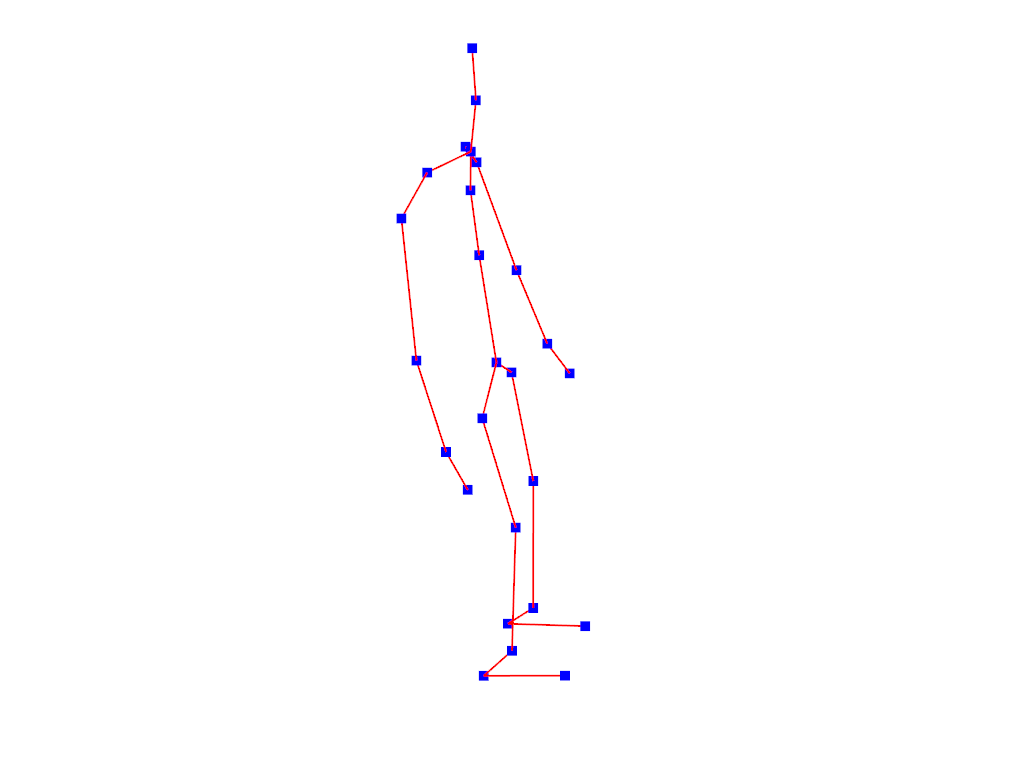

d:\xie\PainAssessment\.venv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (d:\xie\PainAssessment\.venv\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


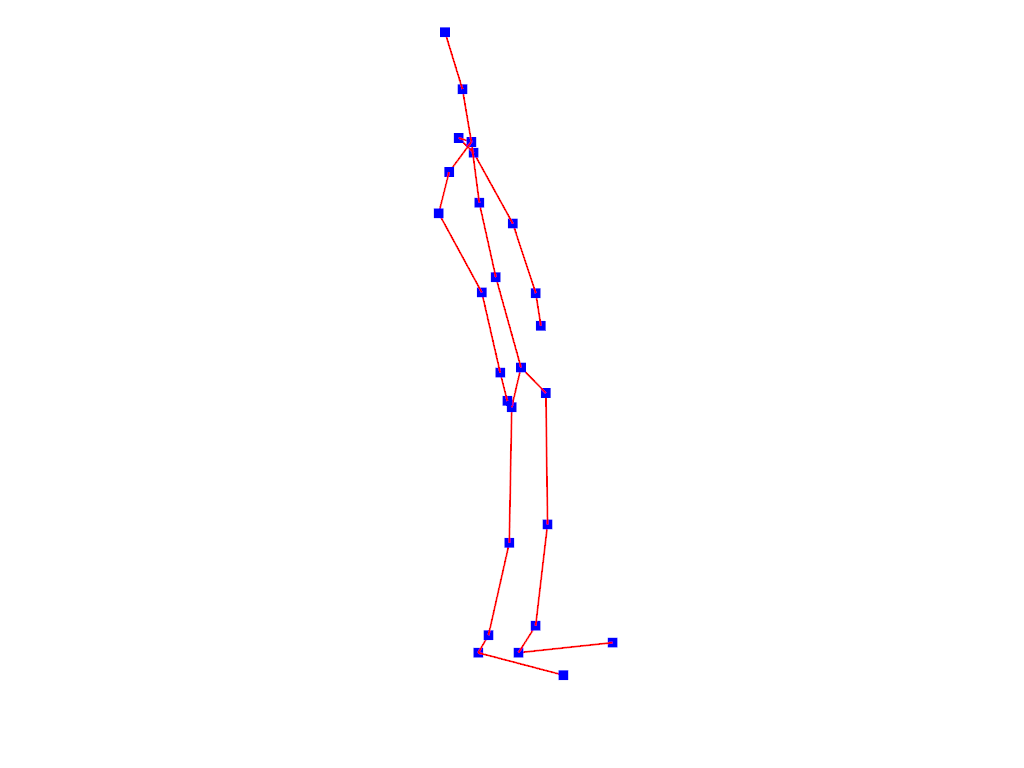

In [204]:
from utils.data_analysis import plot_animation
coo_1 = point_dataset.target_scaler.inverse_transform(test_points[0].cpu().detach().numpy())
coo_2 = point_dataset.target_scaler.inverse_transform(predicted_points[0].cpu().detach().numpy())
plot_animation(coo_1.reshape(-1, 26, 3), 180, 'test_animation.mp4')
plot_animation(coo_2.reshape(-1, 26, 3), 180, 'predicted_animation.mp4')

## with pretrain

### Transformer # of params: 1136732. Best accuracy: 0.7828
### BANet # of params: 1459587
Val auc: 0.6165, Val mcc: 0.4009, 
Val F1_m: 0.6388, Val average accuracy: 0.6667, 

In [ ]:
for batch_features, batch_targets in val_loader:
    print(batch_targets)

In [250]:
# Pretrain the transformer
model = KinematicsTransformer(input_dim, num_classes, seq_len, embed_dim, num_heads, num_layers, dropout=0.5)
print(f"Number of trainable parameters: %d" % sum(p.numel() for p in model.parameters() if p.requires_grad))
torch.cuda.empty_cache()
#pretrain_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
pretrain_loader = train_loader
model.pretrain=True
pre_train_params = list(model.backbone.parameters()) + list(model.reconstruction_head.parameters())
pretrain_transformer(model, pretrain_loader, pretrain_epochs, lr, masking_prob, device, parameters=pre_train_params)

Number of trainable parameters: 1128156
Pretraining Epoch 1/100, Loss: 0.8333
Pretraining Epoch 2/100, Loss: 0.5486
Pretraining Epoch 3/100, Loss: 0.4337
Pretraining Epoch 4/100, Loss: 0.3063
Pretraining Epoch 5/100, Loss: 0.2644
Pretraining Epoch 6/100, Loss: 0.1505
Pretraining Epoch 7/100, Loss: 0.3010
Pretraining Epoch 8/100, Loss: 0.2315
Pretraining Epoch 9/100, Loss: 0.2883
Pretraining Epoch 10/100, Loss: 0.1407
Pretraining Epoch 11/100, Loss: 0.2533
Pretraining Epoch 12/100, Loss: 0.2188
Pretraining Epoch 13/100, Loss: 0.0984
Pretraining Epoch 14/100, Loss: 0.1981
Pretraining Epoch 15/100, Loss: 0.1591
Pretraining Epoch 16/100, Loss: 0.1471
Pretraining Epoch 17/100, Loss: 0.1059
Pretraining Epoch 18/100, Loss: 0.4133
Pretraining Epoch 19/100, Loss: 1.0492
Pretraining Epoch 20/100, Loss: 0.8146
Pretraining Epoch 21/100, Loss: 0.7480
Pretraining Epoch 22/100, Loss: 0.8243
Pretraining Epoch 23/100, Loss: 0.9518
Pretraining Epoch 24/100, Loss: 0.8076
Pretraining Epoch 25/100, Loss: 0

In [251]:
# Fine-tune model
model.pretrain=False
train_params = list(model.prediction_head.parameters())
#train_params = model.parameters()
train_transformer(model, train_loader, val_loader, 100, lr, device,parameters=train_params)

Epoch 1/100, Train Loss: 0.6307, Val Loss: 0.6838, Train accuracy: 0.6975,Train auc: 0.5965, Train mcc: 0.0502, 
	Train F1_m: 0.5224, Train average accuracy: 0.5226, 
	Val accuracy: 0.5571,Val auc: 0.6300, Val mcc: 0.0000, 
	Val F1_m: 0.3578, Val average accuracy: 0.5000, 
	
Epoch 2/100, Train Loss: 0.5905, Val Loss: 0.6890, Train accuracy: 0.7689,Train auc: 0.6268, Train mcc: -0.0375, 
	Train F1_m: 0.4347, Train average accuracy: 0.4969, 
	Val accuracy: 0.5571,Val auc: 0.6622, Val mcc: 0.0000, 
	Val F1_m: 0.3578, Val average accuracy: 0.5000, 
	
Epoch 3/100, Train Loss: 0.5777, Val Loss: 0.6955, Train accuracy: 0.7785,Train auc: 0.6265, Train mcc: 0.0000, 
	Train F1_m: 0.4377, Train average accuracy: 0.5000, 
	Val accuracy: 0.5571,Val auc: 0.6731, Val mcc: 0.0000, 
	Val F1_m: 0.3578, Val average accuracy: 0.5000, 
	
Epoch 4/100, Train Loss: 0.5782, Val Loss: 0.6987, Train accuracy: 0.7687,Train auc: 0.6343, Train mcc: 0.0000, 
	Train F1_m: 0.4346, Train average accuracy: 0.5000, 
	Val

KeyboardInterrupt: 

In [127]:
input_tensor = torch.rand(1, 180, 26).to(device)

# Forward Pass & Extract Attention
model.to(device)
model.train()
#model(input_tensor)

# Extract attention weights
attention = get_first_attention_weights(model, input_tensor)

# Print attention shape
print("Extracted Attention Weights Shape:", attention.shape)  # Expected: (batch_size, seq_len, seq_len)

Extracted Attention Weights Shape: torch.Size([1, 180, 180])


# Reimplement of the BANet Paper
Epoch 150/200, Train Loss: 0.3286, Val Loss: 0.7353, Train Accuracy: 0.6569,Val Accuracy: 0.6162
Epoch 151/200, Train Loss: 0.3310, Val Loss: 0.8068, Train Accuracy: 0.6630,Val Accuracy: 0.6061
Epoch 152/200, Train Loss: 0.3213, Val Loss: 0.7473, Train Accuracy: 0.6473,Val Accuracy: 0.6035
Epoch 153/200, Train Loss: 0.3345, Val Loss: 0.6528, Train Accuracy: 0.6468,Val Accuracy: 0.6566
Epoch 154/200, Train Loss: 0.3217, Val Loss: 0.7409, Train Accuracy: 0.6638,Val Accuracy: 0.6111
Epoch 155/200, Train Loss: 0.3193, Val Loss: 0.8060, Train Accuracy: 0.6675,Val Accuracy: 0.6313
Epoch 156/200, Train Loss: 0.3260, Val Loss: 0.7046, Train Accuracy: 0.6619,Val Accuracy: 0.6566
Epoch 157/200, Train Loss: 0.3166, Val Loss: 0.8827, Train Accuracy: 0.6761,Val Accuracy: 0.6237
Epoch 158/200, Train Loss: 0.3223, Val Loss: 0.7598, Train Accuracy: 0.6691,Val Accuracy: 0.6187
Epoch 159/200, Train Loss: 0.3295, Val Loss: 0.7526, Train Accuracy: 0.6487,Val Accuracy: 0.5909
Epoch 160/200, Train Loss: 0.3244, Val Loss: 0.8485, Train Accuracy: 0.6562,Val Accuracy: 0.6263
Epoch 161/200, Train Loss: 0.3195, Val Loss: 0.7222, Train Accuracy: 0.6566,Val Accuracy: 0.6566
Epoch 162/200, Train Loss: 0.3190, Val Loss: 0.6674, Train Accuracy: 0.6673,Val Accuracy: 0.6566
Epoch 163/200, Train Loss: 0.3216, Val Loss: 0.7340, Train Accuracy: 0.6672,Val Accuracy: 0.5934
Epoch 164/200, Train Loss: 0.3139, Val Loss: 0.7147, Train Accuracy: 0.6754,Val Accuracy: 0.6338
Epoch 165/200, Train Loss: 0.3128, Val Loss: 0.7852, Train Accuracy: 0.6697,Val Accuracy: 0.6086
Epoch 166/200, Train Loss: 0.3173, Val Loss: 0.7253, Train Accuracy: 0.6728,Val Accuracy: 0.6212
Epoch 167/200, Train Loss: 0.3113, Val Loss: 0.7432, Train Accuracy: 0.6812,Val Accuracy: 0.6364
Epoch 168/200, Train Loss: 0.3183, Val Loss: 0.7432, Train Accuracy: 0.6710,Val Accuracy: 0.6540
Epoch 169/200, Train Loss: 0.3166, Val Loss: 0.7069, Train Accuracy: 0.6685,Val Accuracy: 0.6616
Epoch 170/200, Train Loss: 0.3302, Val Loss: 0.7702, Train Accuracy: 0.6636,Val Accuracy: 0.6111
Epoch 171/200, Train Loss: 0.3287, Val Loss: 0.6989, Train Accuracy: 0.6648,Val Accuracy: 0.5732
Epoch 172/200, Train Loss: 0.3114, Val Loss: 0.7560, Train Accuracy: 0.6674,Val Accuracy: 0.5682
Epoch 173/200, Train Loss: 0.3095, Val Loss: 0.7014, Train Accuracy: 0.6768,Val Accuracy: 0.5909
Epoch 174/200, Train Loss: 0.3158, Val Loss: 0.6673, Train Accuracy: 0.6681,Val Accuracy: 0.6212
Epoch 175/200, Train Loss: 0.3109, Val Loss: 0.6385, Train Accuracy: 0.6716,Val Accuracy: 0.6111
Epoch 176/200, Train Loss: 0.3186, Val Loss: 0.6694, Train Accuracy: 0.6679,Val Accuracy: 0.6035
Epoch 177/200, Train Loss: 0.3086, Val Loss: 0.6638, Train Accuracy: 0.6859,Val Accuracy: 0.6136
Epoch 178/200, Train Loss: 0.3156, Val Loss: 0.6710, Train Accuracy: 0.6910,Val Accuracy: 0.6111
Epoch 179/200, Train Loss: 0.3110, Val Loss: 0.6568, Train Accuracy: 0.6907,Val Accuracy: 0.6389
Epoch 180/200, Train Loss: 0.3098, Val Loss: 0.6045, Train Accuracy: 0.6772,Val Accuracy: 0.6389
Epoch 181/200, Train Loss: 0.3198, Val Loss: 0.6112, Train Accuracy: 0.6894,Val Accuracy: 0.6237
Epoch 182/200, Train Loss: 0.3051, Val Loss: 0.6539, Train Accuracy: 0.6793,Val Accuracy: 0.6187
Epoch 183/200, Train Loss: 0.3062, Val Loss: 0.6535, Train Accuracy: 0.6899,Val Accuracy: 0.6061
Epoch 184/200, Train Loss: 0.3066, Val Loss: 0.6695, Train Accuracy: 0.6889,Val Accuracy: 0.6338
Epoch 185/200, Train Loss: 0.3131, Val Loss: 0.6655, Train Accuracy: 0.6816,Val Accuracy: 0.6288
Epoch 186/200, Train Loss: 0.3063, Val Loss: 0.6430, Train Accuracy: 0.6890,Val Accuracy: 0.6111
Epoch 187/200, Train Loss: 0.3105, Val Loss: 0.6521, Train Accuracy: 0.6894,Val Accuracy: 0.6288
Epoch 188/200, Train Loss: 0.3097, Val Loss: 0.6360, Train Accuracy: 0.6835,Val Accuracy: 0.6212
Epoch 189/200, Train Loss: 0.3113, Val Loss: 0.6708, Train Accuracy: 0.6737,Val Accuracy: 0.6111
Epoch 190/200, Train Loss: 0.3158, Val Loss: 0.6715, Train Accuracy: 0.6854,Val Accuracy: 0.6136
Epoch 191/200, Train Loss: 0.3108, Val Loss: 0.6940, Train Accuracy: 0.6846,Val Accuracy: 0.6338
Epoch 192/200, Train Loss: 0.3114, Val Loss: 0.6872, Train Accuracy: 0.6845,Val Accuracy: 0.6364
Epoch 193/200, Train Loss: 0.2975, Val Loss: 0.6914, Train Accuracy: 0.6896,Val Accuracy: 0.6263
Epoch 194/200, Train Loss: 0.3086, Val Loss: 0.7014, Train Accuracy: 0.6953,Val Accuracy: 0.6111
Epoch 195/200, Train Loss: 0.3093, Val Loss: 0.6765, Train Accuracy: 0.6862,Val Accuracy: 0.6364
Epoch 196/200, Train Loss: 0.3057, Val Loss: 0.7137, Train Accuracy: 0.6982,Val Accuracy: 0.6136
Epoch 197/200, Train Loss: 0.3028, Val Loss: 0.6780, Train Accuracy: 0.6898,Val Accuracy: 0.6389
Epoch 198/200, Train Loss: 0.3062, Val Loss: 0.6901, Train Accuracy: 0.6928,Val Accuracy: 0.6010
Epoch 199/200, Train Loss: 0.3116, Val Loss: 0.6774, Train Accuracy: 0.6899,Val Accuracy: 0.5985
Epoch 200/200, Train Loss: 0.3081, Val Loss: 0.6953, Train Accuracy: 0.6915,Val Accuracy: 0.6162

In [156]:
(test_targets>0.5).sum()/test_targets.shape[0]

tensor(0.5000)

In [57]:
model.to(device)
model.eval()
#test_targets=test_targets.to(device)
predictions=model(test_features.to(device)).cpu().detach()
#balanced_accuracy_score(test_targets.mean(dim=-2) > 0.5, predictions.mean(dim=-2).cpu().detach() > 0.5)
test_targets = torch.concatenate((1- test_targets, test_targets), -1)
nn.CrossEntropyLoss()(predictions, test_targets)

tensor(0.6919)

In [63]:
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, roc_auc_score, balanced_accuracy_score

f1=f1_score(test_targets[:,1] > 0.5, predictions[:,1] > 0.5)
accuracy=accuracy_score(test_targets[:,1] > 0.5, predictions[:,1] > 0.5)
balanced_accuracy = balanced_accuracy_score(test_targets[:,1] > 0.5, predictions[:,1] > 0.5)
print(f1, accuracy, balanced_accuracy)

0.5974025974025974 0.6085858585858586 0.6085858585858586


In [76]:
X, Y =[], []
for x,y in train_loader:
    X.append(x)
    Y.append(y)

X = torch.cat(X)
Y = torch.cat(Y)

In [ ]:
x,y=dataset.get_train_data()
import matplotlib.pyplot as plt
plt.hist(torch.max(y, dim=1)[0])